In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
from scipy import signal

In [51]:
import theano
from theano import tensor as T
import lasagne
from lasagne.layers import InputLayer, Conv2DLayer

In [73]:
from skimage.io import imread

(-0.5, 511.5, 511.5, -0.5)

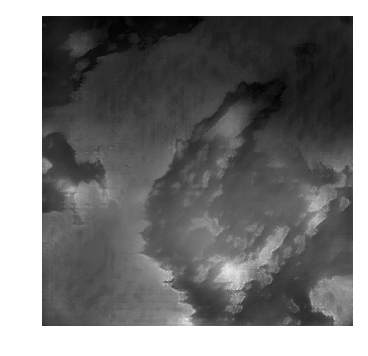

In [96]:
hm = imread("18.png")[:,:,0]
hm = hm.astype("float32") / 255.
plt.imshow(hm,cmap="gray")
plt.axis('off')

In [81]:
hm.shape

(512, 512, 3)

In [88]:
l_in = InputLayer((None, 1, 512, 512))
l_conv = Conv2DLayer(l_in, num_filters=1, filter_size=7, pad='same')

In [89]:
l_conv.W.get_value().shape

(1, 1, 7, 7)

In [90]:
import scipy.stats as st

def gkern(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel array."""

    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

In [91]:
f = l_conv.W.get_value()
f[0,0,:,:] = gkern(l_conv.W.get_value().shape[-1],3)
l_conv.W.set_value(f)

In [92]:
conv_out = lasagne.layers.get_output(l_conv, l_conv.input_layer.input_var)

In [93]:
tmp = conv_out.eval({l_conv.input_layer.input_var: hm[np.newaxis,np.newaxis]})

(-0.5, 511.5, 511.5, -0.5)

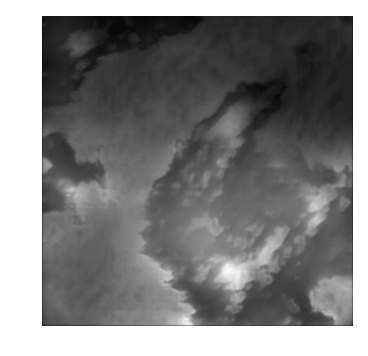

In [95]:
plt.imshow(tmp[0][0],cmap="gray")
plt.axis('off')